In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

/tmp/ipykernel_11442/2400937917.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Logistic Regression as ANN

The binary logistic regression model is defined as:

$$
\begin{align*}
y_i & \sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) & = \beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}
\end{align*}
$$

where $y_i$ is the binary response variable, $p_i$ is the probability of $y_i = 1$, and $x_{ij}$ are the predictor variables. In statistics courses you may have encountered the Maximum Likehood Estimation (MLE) method to estimate the coefficients $\beta_j$. The likelihood function of the model (assuming independence of the observations) is:

$$
\begin{align*}
L(\beta) & = \prod_{i=1}^n p_i^{y_i} (1 - p_i)^{1 - y_i} \\
\log L(\beta) & = \sum_{i=1}^n y_i \log(p_i) + (1 - y_i) \log(1 - p_i)
\end{align*}
$$

The MLE method estimates the coefficients $\beta_j$ by maximizing the log-likelihood function. This is usually done using optimization algorithms like [Newton-Raphson](https://personal.math.ubc.ca/~anstee/math104/newtonmethod.pdf) which is implemented in R's `glm` function.

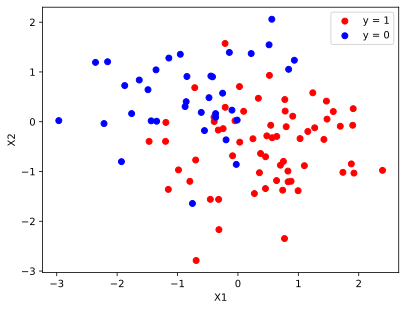

In [41]:
# Generate some fake data for demonstration
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

n = 100
p = 2

X = np.random.randn(n, p)
beta = np.array([1.7, -2])

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

probs = sigmoid(X @ beta + 1)
y = np.random.binomial(1, probs)

# Plot the data 

plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [15]:
logreg = LogisticRegression(penalty=None, fit_intercept=True)
logreg.fit(X, y.squeeze())
print(logreg.coef_)

[[ 1.54237797 -1.85846244]]


In [42]:
beta.T

array([ 1.7, -2. ])

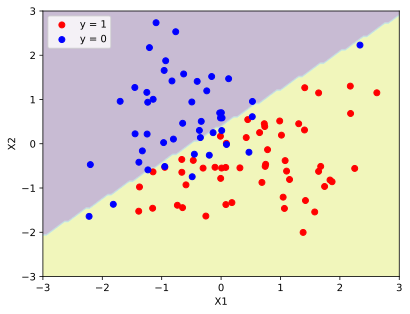

In [24]:
# Plot the decision boundary

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)

X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]
y_grid = logreg.predict(X_grid).reshape(X1.shape)

plt.contourf(X1, X2, y_grid, alpha=0.3)
plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Logistic Regression as a ANN

As the linear regression model, the logistic regression model can be seen as a single-layer artificial neural network. The model is defined as:

$$
\hat{y}_i = \sigma(b + w_1 x_{i1} + \ldots + w_p x_{ip}) = \sigma(b + w^T x_i)
$$

The predictions are again made using the dot product of the input features and the weights, plus a bias term. The difference is that the output is passed through the sigmoid function, which maps the output to the interval $[0, 1]$. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


```{mermaid}
%%| label: fig-single-neuron
%%| fig-width: 6
%%| fig-cap: "ANN model for linear regression for a single observation"

graph LR
    x1["$$x_{i1}$$"] -->|$$w_1$$| B(($$w^T x_i + b$$))
    x2["$$x_{i2}$$"] -->|$$w_2$$| B
    xp["$$x_{ip}$$"] -->|$$w_p$$| B
    B --> |"$$\sigma$$"|C["$$\hat{y}$$"]
```

The loss function for logistic regression is the binary cross-entropy:

$$
L_i = -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i)
$$

Its derivative with respect to the weights is:

$$
\frac{\partial L_i}{\partial w_j} = (y_i - \hat{y}_i) x_{ij}
$$

and with respect to the bias:

$$
\frac{\partial L_i}{\partial b} = (y_i - \hat{y}_i)
$$

Using these gradients, we can derive the update rules for the weights and the bias:

$$
w^{t + 1}_j = w^{t}_j + \eta \sum_i (y_i - \hat{y}_i) x_{ij}
$$

$$
b^{t + 1} = b^{t} + \eta \sum_i (y_i - \hat{y}_i)
$$

where $\eta$ is the learning rate.



In [58]:
# Fit a logistic regression model using PyTorch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

logreg_ann = nn.Sequential(
    nn.Linear(p, 1),
    nn.Sigmoid()
)

losses = []

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(logreg_ann.parameters(), lr=0.02)

for i in range(20000):
    y_pred = logreg_ann(X_tensor).squeeze()
    loss = criterion(y_pred, y_tensor)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, loss = {loss.item()}')
    

Iteration 0, loss = 0.7572871446609497
Iteration 100, loss = 0.5200338959693909
Iteration 200, loss = 0.4374050796031952
Iteration 300, loss = 0.39996054768562317
Iteration 400, loss = 0.37963366508483887
Iteration 500, loss = 0.3672719895839691
Iteration 600, loss = 0.3591638207435608
Iteration 700, loss = 0.3535550832748413
Iteration 800, loss = 0.34952080249786377
Iteration 900, loss = 0.34653156995773315
Iteration 1000, loss = 0.34426483511924744
Iteration 1100, loss = 0.3425138592720032
Iteration 1200, loss = 0.34114086627960205
Iteration 1300, loss = 0.34005072712898254
Iteration 1400, loss = 0.3391761779785156
Iteration 1500, loss = 0.33846837282180786
Iteration 1600, loss = 0.337891161441803
Iteration 1700, loss = 0.3374173641204834
Iteration 1800, loss = 0.3370262384414673
Iteration 1900, loss = 0.33670181035995483
Iteration 2000, loss = 0.33643147349357605
Iteration 2100, loss = 0.3362053334712982
Iteration 2200, loss = 0.3360155522823334
Iteration 2300, loss = 0.335855722427

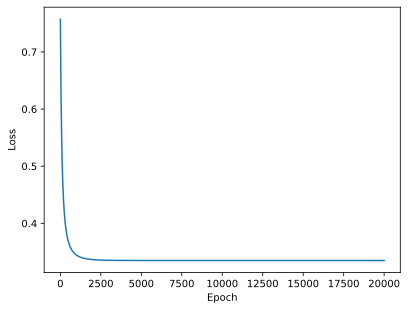

In [59]:
# Plot the loss curve

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [60]:
# Extract the weights from the model

weights = [param.data.numpy() for param in logreg_ann.parameters()]
weights

[array([[ 1.7466282, -1.8371977]], dtype=float32),
 array([0.9665339], dtype=float32)]

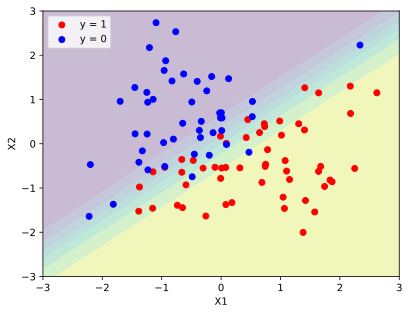

In [35]:
# Plot the decision boundary

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)

X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)
y_grid = logreg_ann(X_grid_tensor).detach().numpy().reshape(X1.shape)

plt.contourf(X1, X2, y_grid, alpha=0.3)
plt.scatter(X[y.squeeze() == 1, 0], X[y.squeeze() == 1, 1], color='red', label='y = 1')
plt.scatter(X[y.squeeze() == 0, 0], X[y.squeeze() == 0, 1], color='blue', label='y = 0')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

/tmp/ipykernel_11442/3516816886.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses[epoch] = epoch_loss / n


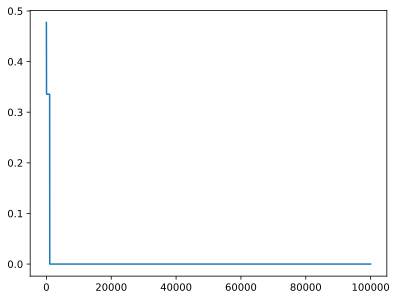

In [53]:
# Exercise: Implement the logistic regression model using `numpy`. See how the linear regression
# model was implemented in the previous section for guidance.



In [54]:
# w

array([ 1.74152592, -1.8398871 ])

In [55]:
# b

array([0.9719365])

In [56]:
# logreg.coef_

array([[ 1.54237797, -1.85846244]])